<a href="https://colab.research.google.com/github/NegativeGravity/Heuristic_Trader/blob/main/New_Trader_Stationary_Ensamble_risk_managment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import copy
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Literal
from numba import njit
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from google.colab import drive
import os
from itertools import combinations

In [ ]:
# ==========================================
# 1. CONFIGURATION & TYPES (UPDATED FOR NSGA-II & ISLANDS)
# ==========================================
from dataclasses import dataclass

@dataclass(frozen=True)
class Config:
    """
    Immutable configuration for the trading system.
    Updated with CPCV (Combinato UI rial Purged Cross-Validation) parameters.
    """

    # --- Risk Management ---
    risk_per_trade: float = 0.01
    reward_risk_ratio: float = 2.0
    sl_min: float = 0.005
    sl_max: float = 0.04
    initial_capital: float = 1000.0
    commission: float = 0.0006

    # --- Genetic Algorithm (NSGA-II + Island Model) ---
    pop_size: int = 50         # Total population size across all islands
    n_islands: int = 4          # Number of sub-populations for diversity
    migration_interval: int = 5 # Generations between island migrations
    migration_rate: float = 0.1 # Ratio of migrants
    n_generations: int = 200    # Optimized: Reduced to prevent overfitting to noise
    mutation_rate: float = 0.15
    max_conditions: int = 5     # Max rules per strategy (Ockham's Razor)
    min_trades: int = 15        # Increased to ensure statistical robustness

    # --- CPCV (Combinatorial Purged Cross-Validation) Settings ---
    # These parameters control how data is split into paths for testing
    n_bins: int = 6             # Total number of blocks to split the data into
    k_test_bins: int = 2        # Number of blocks used for testing in each path
    purge_bars: int = 50        # Gap to remove around test sets to prevent leakage
    embargo_pct: float = 0.01   # Data to discard after test sets to break serial correlation

    # --- Legacy / WFA Settings ---
    # Kept for compatibility with existing data loading logic
    train_window: int = 15000
    test_window: int = 15000

    # --- Structural Complexity Settings ---
    # Coefficient to penalize each additional active condition
    complexity_penalty: float = 0.05

    # --- Fractional Differentiation Settings ---
    # 'd' value (usually between 0.2 and 0.6) to preserve memory while achieving stationarity
    frac_diff_d: float = 0.35
    frac_diff_threshold: float = 1e-4

@dataclass
class Chromosome:
    """Represents a trading strategy candidate with NSGA-II attributes."""
    active_conds: np.ndarray
    feature_idxs: np.ndarray
    operators: np.ndarray
    threshold_quantiles: np.ndarray
    sl_gene: float

    # NSGA-II Attributes
    fitness_profit: float = -np.inf  # Objective 1 (Maximize)
    fitness_dd: float = np.inf       # Objective 2 (Minimize)
    trades: int = 0
    rank: int = 0                    # Pareto Rank (0 is best)
    crowding_dist: float = 0.0       # Crowding Distance (for diversity)

    # New Reporting Attributes
    wins: int = 0
    losses: int = 0
    total_win_amt: float = 0.0
    total_loss_amt: float = 0.0

    def dominates(self, other: 'Chromosome') -> bool:
        """
        Check if self dominates other.
        Objectives: Max Profit, Min DD.
        Constraint: Min Trades (Penalized if not met).
        """
        # Hard Constraint Check: If trade count < 10, it's dominated by valid ones
        valid_self = self.trades >= 10
        valid_other = other.trades >= 10

        if valid_self and not valid_other:
            return True
        if not valid_self and valid_other:
            return False
        if not valid_self and not valid_other:
            # If both invalid, prefer the one with more trades
            return self.trades > other.trades

        # Pareto Dominance Logic (Max Profit, Min DD)
        # 1. Self is no worse in all objectives
        not_worse = (self.fitness_profit >= other.fitness_profit) and \
                    (self.fitness_dd <= other.fitness_dd)

        # 2. Self is strictly better in at least one objective
        strictly_better = (self.fitness_profit > other.fitness_profit) or \
                          (self.fitness_dd < other.fitness_dd)

        return not_worse and strictly_better

In [ ]:
# ==========================================
# 2. NUMBA OPTIMIZED CORE (The Engine)
# ==========================================

@njit(fastmath=True)
def calculate_signals_numba(n_rows, max_conds, active_conds, feature_idxs,
                          operators, thresholds, feature_matrix):
    """
    Generates trading signals for a single chromosome.
    Checks if all active conditions are met for each row.
    """
    signal_mask = np.ones(n_rows, dtype=np.bool_)
    active_count = 0

    for i in range(max_conds):
        if active_conds[i] == 1:
            active_count += 1
            col_data = feature_matrix[:, feature_idxs[i]]
            thresh_val = thresholds[i]

            # Operator 0: < (Less Than), Operator 1: > (Greater Than)
            if operators[i] == 0:
                for r in range(n_rows):
                    if not (col_data[r] < thresh_val): signal_mask[r] = False
            else:
                for r in range(n_rows):
                    if not (col_data[r] > thresh_val): signal_mask[r] = False

    if active_count == 0:
        return np.zeros(n_rows, dtype=np.bool_), 0
    return signal_mask, active_count

# --- INDIVIDUAL BACKTEST (Used for Phase 1 & 2 Training) ---

@njit(fastmath=True)
def backtest_numba_stats(close_prices, signals, side, sl_pct, rr, init, risk, comm):
    """
    Standard individual backtest engine for chromosome fitness evaluation.
    Calculates Net Profit, Drawdown, and Win/Loss amounts independently.
    """
    n = len(close_prices)
    eq, peak, max_dd = init, init, 0.0
    wins, losses, win_amt, loss_amt = 0, 0, 0.0, 0.0
    tp_pct = sl_pct * rr

    i = 0
    while i < n - 1:
        if eq > peak: peak = eq
        dd = (peak - eq) / peak
        if dd > max_dd: max_dd = dd

        if signals[i]:
            entry = close_prices[i]
            if entry <= 0:
                i += 1
                continue
            sz = (eq * risk) / (entry * sl_pct)

            done = False
            for j in range(i + 1, n):
                pnl = ((close_prices[j] - entry) / entry) * side
                if pnl >= tp_pct:
                    val = (sz * entry * tp_pct) - ((sz * entry + sz * close_prices[j]) * comm)
                    eq += val; win_amt += val; wins += 1; i, done = j, True; break
                elif pnl <= -sl_pct:
                    val = -(sz * entry * sl_pct) - ((sz * entry + sz * close_prices[j]) * comm)
                    eq += val; loss_amt += abs(val); losses += 1; i, done = j, True; break
            if not done: i += 1
        else: i += 1
    return wins, losses, eq - init, max_dd, win_amt, loss_amt

# --- ENSEMBLE BACKTEST & CURVES (Used for Phase 3 Testing) ---

@njit(fastmath=True)
def backtest_ensemble_numba(close_prices, ensemble_signals, side, avg_sl, rr, init, comm):
    """
    Core Ensemble Engine for collective performance statistics.
    Implements Consensus Entry and Dynamic Risk Scaling (1% to 5%).
    """
    n_chroms, n_rows = ensemble_signals.shape
    eq, peak, max_dd = init, init, 0.0
    wins, losses, tp_pct = 0, 0, avg_sl * rr

    i = 0
    while i < n_rows - 1:
        if eq > peak: peak = eq
        cur_dd = (peak - eq) / peak
        if dd > max_dd: max_dd = cur_dd

        # Calculate voting agreement among all Pareto Elites
        votes = 0
        for c in range(n_chroms):
            if ensemble_signals[c, i]: votes += 1
        agreement = votes / n_chroms

        # Ensemble Entry Requirement: Minimum 50% Consensus
        if agreement >= 0.5:
            # Dynamic Risk Logic: 1% risk at 50% agreement, scaling to 5% at 100% agreement
            risk = 0.01 + ((agreement - 0.5) / 0.5) * 0.04
            entry = close_prices[i]
            if entry <= 0:
                i += 1
                continue

            position_size = (eq * risk) / (entry * avg_sl)
            done = False
            for j in range(i + 1, n_rows):
                pnl = ((close_prices[j] - entry) / entry) * side
                if pnl >= tp_pct:
                    eq += (position_size * entry * tp_pct) - ((position_size * entry + position_size * close_prices[j]) * comm)
                    wins += 1; i, done = j, True; break
                elif pnl <= -avg_sl:
                    eq -= (position_size * entry * avg_sl) + ((position_size * entry + position_size * close_prices[j]) * comm)
                    losses += 1; i, done = j, True; break
            if not done: i += 1
        else: i += 1
    return wins, losses, eq - init, max_dd

@njit(fastmath=True)
def get_trade_history_numba(close_prices: np.ndarray,
                            signals: np.ndarray,
                            side: int,
                            sl_pct: float,
                            rr_ratio: float,
                            init_capital: float,
                            risk_per_trade: float,
                            commission: float) -> np.ndarray:
    """
    Returns an array of realized Profit/Loss ($) for EACH trade sequentially.
    Used for plotting Equity vs Trade Number.
    """
    n_rows = len(close_prices)
    current_equity = init_capital
    tp_pct = sl_pct * rr_ratio

    # Use a list to store trade results
    trade_pnls = []

    i = 0
    while i < n_rows - 1:
        if signals[i]:
            entry_price = close_prices[i]
            risk_amt = current_equity * risk_per_trade

            if entry_price <= 0:
                i += 1
                continue

            position_size = risk_amt / (entry_price * sl_pct)
            outcome = 0

            for j in range(i + 1, n_rows):
                current_price = close_prices[j]

                raw_return = (current_price - entry_price) / entry_price
                pnl_pct = raw_return * side

                trade_pnl = 0.0
                trade_finished = False

                # Check TP
                if pnl_pct >= tp_pct:
                    gross_profit = position_size * entry_price * tp_pct
                    cost = (position_size * entry_price + position_size * current_price) * commission
                    trade_pnl = gross_profit - cost
                    current_equity += trade_pnl
                    trade_finished = True
                    outcome = 1

                # Check SL
                elif pnl_pct <= -sl_pct:
                    gross_loss = position_size * entry_price * sl_pct
                    cost = (position_size * entry_price + position_size * current_price) * commission
                    trade_pnl = -(gross_loss + cost)
                    current_equity += trade_pnl
                    trade_finished = True
                    outcome = -1

                if trade_finished:
                    trade_pnls.append(trade_pnl)
                    i = j
                    break

            if outcome == 0:
                i += 1
        else:
            i += 1

    return np.array(trade_pnls)

@njit(fastmath=True)
def get_ensemble_trade_history_numba(close_prices, ensemble_signals, side, avg_sl, rr, init, comm):
    """
    Returns an array of realized PnL values for trades where consensus >= 50%.
    Used for plotting the Trade-Based Equity Curve.
    """
    n_chroms, n_rows = ensemble_signals.shape
    eq = init
    tp_pct = avg_sl * rr
    pnls = []

    i = 0
    while i < n_rows - 1:
        votes = 0
        for c in range(n_chroms):
            if ensemble_signals[c, i]: votes += 1
        agreement = votes / n_chroms

        # Only execute if the team agrees (50% or more)
        if agreement >= 0.5:
            # Scale risk based on agreement level (1% to 5%)
            risk = 0.01 + ((agreement - 0.5) / 0.5) * 0.04
            entry = close_prices[i]
            if entry <= 0:
                i += 1
                continue

            position_size = (eq * risk) / (entry * avg_sl)
            done = False
            for j in range(i + 1, n_rows):
                pnl_p = ((close_prices[j] - entry) / entry) * side
                if pnl_p >= tp_pct:
                    val = (position_size * entry * tp_pct) - ((position_size * entry + position_size * close_prices[j]) * comm)
                    eq += val; pnls.append(val); i, done = j, True; break
                elif pnl_p <= -avg_sl:
                    val = -((position_size * entry * avg_sl) + ((position_size * entry + position_size * close_prices[j]) * comm))
                    eq += val; pnls.append(val); i, done = j, True; break
            if not done: i += 1
        else: i += 1
    return np.array(pnls)

@njit(fastmath=True)
def get_ensemble_equity_curve_numba(close_prices, ensemble_signals, side, avg_sl, rr, init, comm):
    """
    Generates a candle-by-candle equity curve for the Ensemble team.
    Equity remains flat when consensus is below 50%.
    """
    n_chroms, n_rows = ensemble_signals.shape
    curve = np.zeros(n_rows, dtype=np.float64)
    eq = init
    curve[:] = eq
    tp_pct = avg_sl * rr

    i = 0
    while i < n_rows - 1:
        curve[i] = eq
        votes = 0
        for c in range(n_chroms):
            if ensemble_signals[c, i]: votes += 1
        agreement = votes / n_chroms

        if agreement >= 0.5:
            risk = 0.01 + ((agreement - 0.5) / 0.5) * 0.04
            entry = close_prices[i]
            sz = (eq * risk) / (entry * avg_sl)
            done = False
            for j in range(i + 1, n_rows):
                curve[j] = eq
                pnl = ((close_prices[j] - entry) / entry) * side
                if pnl >= tp_pct:
                    eq += (sz * entry * tp_pct) - ((sz * entry + sz * close_prices[j]) * comm)
                    curve[j] = eq; i, done = j, True; break
                elif pnl <= -avg_sl:
                    eq -= (sz * entry * avg_sl) + ((sz * entry + sz * close_prices[j]) * comm)
                    curve[j] = eq; i, done = j, True; break
            if not done: i += 1
        else: i += 1
    curve[i:] = eq
    return curve

def plot_trades_equity_curve(trade_pnls: List[float], title: str, initial_capital: float):
    """
    Plots Equity Curve vs Trade Count (Discrete trades).
    """
    if len(trade_pnls) == 0:
        print(f"   ⚠️ No trades to plot for {title}")
        return

    cumulative_pnl = np.cumsum(trade_pnls)
    equity_series = initial_capital + cumulative_pnl

    # Add starting point (Trade 0)
    equity_series = np.insert(equity_series, 0, initial_capital)

    plt.figure(figsize=(10, 4))
    plt.plot(equity_series, marker='o', linestyle='-', markersize=3, color='teal', alpha=0.8)
    plt.title(f"{title} (Per Trade)")
    plt.ylabel('Equity ($)')
    plt.xlabel('Trade Count (#)')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# ==========================================
# 3. CLUSTERING & GENETIC ALGORITHM LOGIC (IMPROVED)
# ==========================================

def perform_advanced_clustering(df: pd.DataFrame, n_clusters: int) -> Dict[int, List[int]]:
    """
    Advanced Clustering based on Predictive Rolling Correlation (Rank IC).
    Improved with robustness against non-finite values and zero-variance features.
    """
    # 1. Prepare Features and Target
    feature_cols = [c for c in df.columns if c != 'close']
    if not feature_cols:
        return {0: [0]}

    future_returns = df['close'].pct_change().shift(-1)

    # Use a dynamic rolling window based on data size
    rolling_window = min(30, len(df) // 5)

    if len(df) < rolling_window + 10:
        # Fallback for very small datasets
        return {i: [i % len(feature_cols)] for i in range(n_clusters)}

    # 2. Calculate Rolling Rank IC for each feature
    # We rank to be robust against outliers
    ranked_returns = future_returns.rank(pct=True)
    rolling_ic_dict = {}

    for col in feature_cols:
        ranked_feature = df[col].rank(pct=True)
        # Calculate rolling correlation with target
        ic = ranked_feature.rolling(window=rolling_window).corr(ranked_returns)
        rolling_ic_dict[col] = ic

    # 3. Handle Non-Finite Values in IC Matrix
    df_rolling_ic = pd.DataFrame(rolling_ic_dict)
    # Fill NaNs from early rolling window with 0
    df_rolling_ic = df_rolling_ic.fillna(0)

    # Remove columns that have zero variance (all zeros/constant)
    # as they cause NaNs in the meta-correlation matrix
    df_rolling_ic = df_rolling_ic.loc[:, (df_rolling_ic != df_rolling_ic.iloc[0]).any()]

    if df_rolling_ic.empty or df_rolling_ic.shape[1] < 2:
        # Fallback if no valid features remain
        return {i: [i % len(feature_cols)] for i in range(n_clusters)}

    # 4. Meta-Correlation Matrix (Similarity of predictive behavior)
    meta_corr_matrix = df_rolling_ic.corr(method='spearman').fillna(0)

    # 5. Distance Matrix Calculation
    # We use 1 - abs(corr) to group features that move together (or opposite)
    dist_matrix = 1 - np.abs(meta_corr_matrix.values)

    # ULTIMATE SAFETY: Ensure symmetry and finite values for SciPy
    np.fill_diagonal(dist_matrix, 0)
    dist_matrix = (dist_matrix + dist_matrix.T) / 2 # Ensure symmetry
    dist_matrix = np.nan_to_num(dist_matrix, nan=1.0, posinf=1.0, neginf=1.0)
    dist_matrix = np.clip(dist_matrix, 0, 1)

    try:
        # Convert to condensed distance vector
        dist_vec = squareform(dist_matrix, checks=False)

        # 6. Hierarchical Clustering (Ward's Method)
        Z = linkage(dist_vec, method='ward')

        # Determine cluster labels
        # maxclust ensures we get exactly n_clusters if possible
        labels = fcluster(Z, t=n_clusters, criterion='maxclust')

        # 7. Map clusters to feature indices
        cluster_map = {k: [] for k in range(n_clusters)}
        actual_features_names = df_rolling_ic.columns.tolist()
        original_feature_to_idx = {name: i for i, name in enumerate(feature_cols)}

        for name, label in zip(actual_features_names, labels):
            # Convert back to 0-based index for the Genetic Algorithm
            cluster_idx = (label - 1) % n_clusters
            cluster_map[cluster_idx].append(original_feature_to_idx[name])

        # 8. Final Check: Ensure no empty clusters
        all_valid_indices = list(range(len(feature_cols)))
        for k in range(n_clusters):
            if not cluster_map[k]:
                cluster_map[k] = [random.choice(all_valid_indices)]

        return cluster_map

    except Exception as e:
        print(f"   ⚠️ Clustering Error: {e}. Falling back to random distribution.")
        # Robust fallback: Randomly distribute features into clusters
        fallback_map = {k: [] for k in range(n_clusters)}
        for i in range(len(feature_cols)):
            fallback_map[i % n_clusters].append(i)
        return fallback_map

def create_random_chromosome(cluster_map: Dict[int, List[int]], cfg: Config) -> Chromosome:
    """
    Creates a chromosome with 'Sparsity Bias'.
    Instead of activating random conditions, we force valid signals by starting simple.
    """
    selected_features = np.zeros(cfg.max_conditions, dtype=np.int64)

    # 1. Select Features
    for i in range(cfg.max_conditions):
        cluster_indices = cluster_map[i]
        selected_features[i] = random.choice(cluster_indices)

    # 2. Sparsity Logic (KEY CHANGE)
    # Instead of random 0/1 for all, we pick 1 to 3 active conditions max.
    # This ensures high probability of signal generation initially.
    active_conds = np.zeros(cfg.max_conditions, dtype=np.int64)

    # Randomly pick how many conditions to activate (1, 2, or 3)
    # Bias towards 1 or 2 for higher signal count
    num_active = random.choices([1, 2, 3], weights=[50, 30, 20], k=1)[0]
    num_active = min(num_active, cfg.max_conditions)

    active_indices = random.sample(range(cfg.max_conditions), num_active)
    active_conds[active_indices] = 1

    return Chromosome(
        active_conds=active_conds,
        feature_idxs=selected_features,
        operators=np.random.randint(0, 2, size=cfg.max_conditions).astype(np.int64),
        threshold_quantiles=np.random.uniform(0.10, 0.90, size=cfg.max_conditions), # Avoid extremes
        sl_gene=np.random.random()
    )

def fast_non_dominated_sort(population: List[Chromosome]) -> List[List[Chromosome]]:
    """Sorts population into Pareto Fronts."""
    fronts = [[]]
    for p in population:
        p.domination_count = 0
        p.dominated_solutions = []
        for q in population:
            if p.dominates(q):
                p.dominated_solutions.append(q)
            elif q.dominates(p):
                p.domination_count += 1
        if p.domination_count == 0:
            p.rank = 0
            fronts[0].append(p)

    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = i + 1
                    next_front.append(q)
        i += 1
        if len(next_front) > 0:
            fronts.append(next_front)
        else:
            break
    return fronts[:-1] if len(fronts[-1]) == 0 else fronts

def calculate_crowding_distance(front: List[Chromosome]):
    """Assigns crowding distance."""
    l = len(front)
    if l == 0: return
    for p in front: p.crowding_dist = 0.0
    if l <= 2:
        for p in front: p.crowding_dist = float('inf')
        return

    # Sort by Profit
    front.sort(key=lambda x: x.fitness_profit)
    front[0].crowding_dist = float('inf')
    front[-1].crowding_dist = float('inf')
    rng_prof = front[-1].fitness_profit - front[0].fitness_profit
    if rng_prof == 0: rng_prof = 1.0

    for i in range(1, l-1):
        front[i].crowding_dist += (front[i+1].fitness_profit - front[i-1].fitness_profit) / rng_prof

    # Sort by DD
    front.sort(key=lambda x: x.fitness_dd)
    front[0].crowding_dist = float('inf')
    front[-1].crowding_dist = float('inf')
    rng_dd = front[-1].fitness_dd - front[0].fitness_dd
    if rng_dd == 0: rng_dd = 1.0

    for i in range(1, l-1):
        front[i].crowding_dist += (front[i+1].fitness_dd - front[i-1].fitness_dd) / rng_dd

def evaluate_chromosome(chrom: Chromosome, feature_matrix: np.ndarray, close_prices: np.ndarray, side: int, cfg: Config):
    """
    Evaluates a strategy candidate.
    Includes Structural Complexity Penalty to prevent over-engineering.
    """
    # 1. Decode Thresholds from Quantiles
    # We use nanquantile to find the actual feature value for each active condition
    actual_thresholds = np.zeros(cfg.max_conditions, dtype=np.float64)
    for k in range(cfg.max_conditions):
        if chrom.active_conds[k]:
            idx = chrom.feature_idxs[k]
            actual_thresholds[k] = np.nanquantile(feature_matrix[:, idx], chrom.threshold_quantiles[k])

    # 2. Generate Trading Signals
    # Uses the Numba-optimized engine for speed
    signals, n_active = calculate_signals_numba(
        len(close_prices), cfg.max_conditions,
        chrom.active_conds, chrom.feature_idxs, chrom.operators,
        actual_thresholds, feature_matrix
    )

    total_signals = np.sum(signals)
    if n_active == 0 or total_signals == 0:
        chrom.fitness_profit, chrom.fitness_dd, chrom.trades = -1e6, 1.0, 0
        return

    # 3. Run Core Backtest
    # Calculates PnL, Drawdown, and Win/Loss metrics
    sl_pct = cfg.sl_min + chrom.sl_gene * (cfg.sl_max - cfg.sl_min)
    wins, losses, net_profit, max_dd, win_amt, loss_amt = backtest_numba_stats(
        close_prices, signals, side, sl_pct, cfg.reward_risk_ratio,
        cfg.initial_capital, cfg.risk_per_trade, cfg.commission
    )

    # 4. Final Fitness Assignment with Complexity Penalty
    total_trades = wins + losses
    chrom.trades = total_trades
    chrom.wins, chrom.losses = wins, losses
    chrom.total_win_amt, chrom.total_loss_amt = win_amt, loss_amt

    if total_trades < cfg.min_trades:
        # Linear penalty for not meeting the minimum trade count requirement
        chrom.fitness_profit = -1000.0 * (cfg.min_trades - total_trades)
        chrom.fitness_dd = 1.0
    else:
        # Calculate Expectancy (Average Profit per Trade)
        expectancy = net_profit / total_trades

        # Profit Factor filter: penalize rules with low profit factor
        pf = win_amt / abs(loss_amt) if loss_amt > 0 else (10.0 if win_amt > 0 else 0.0)
        if pf < 1.5:
            expectancy *= 0.5

        # --- STRUCTURAL COMPLEXITY PENALTY (Occam's Razor) ---
        # Penalize each additional condition to discourage over-fitting.
        # A 2-condition rule is preferred over a 5-condition rule if performance is similar.
        complexity_factor = 1.0 - (cfg.complexity_penalty * (n_active - 1))

        # Objective 1: Maximize Adjusted Expectancy
        chrom.fitness_profit = expectancy * max(0.1, complexity_factor)

        # Objective 2: Minimize Max Drawdown
        chrom.fitness_dd = max_dd

def create_offspring(p1: Chromosome, p2: Chromosome, cluster_map: Dict, cfg: Config) -> Chromosome:
    """Standard Crossover & Mutation"""
    child = copy.deepcopy(p1)

    # Crossover
    for i in range(cfg.max_conditions):
        if random.random() < 0.5:
            child.active_conds[i] = p2.active_conds[i]
            child.feature_idxs[i] = p2.feature_idxs[i]
            child.operators[i] = p2.operators[i]
            child.threshold_quantiles[i] = p2.threshold_quantiles[i]

    if random.random() < 0.5: child.sl_gene = p2.sl_gene

    # Mutation
    if random.random() < cfg.mutation_rate:
        idx = random.randint(0, cfg.max_conditions - 1)
        child.active_conds[idx] = 1 - child.active_conds[idx]

        # Safety: Ensure at least 1 condition remains active after mutation
        if np.sum(child.active_conds) == 0:
            child.active_conds[idx] = 1

    if random.random() < cfg.mutation_rate:
        idx = random.randint(0, cfg.max_conditions - 1)
        child.feature_idxs[idx] = random.choice(cluster_map[idx])

    if random.random() < cfg.mutation_rate:
        idx = random.randint(0, cfg.max_conditions - 1)
        child.threshold_quantiles[idx] = np.clip(
            child.threshold_quantiles[idx] + np.random.normal(0, 0.1), 0.05, 0.95
        )

    return child

def tournament_selection_nsga2(pop: List[Chromosome], cluster_map: Dict, cfg: Config) -> Chromosome:
    """
    Bulletproof Tournament Selection.
    Guarantees a valid Chromosome is always returned.
    """
    if not pop:
        # Emergency Fallback: Create a new random candidate if population is empty
        return create_random_chromosome(cluster_map, cfg)

    if len(pop) < 2:
        return pop[0]

    i, j = random.sample(range(len(pop)), 2)
    p1, p2 = pop[i], pop[j]

    # NSGA-II Selection Logic
    if p1.rank < p2.rank:
        return p1
    elif p2.rank < p1.rank:
        return p2
    else:
        return p1 if p1.crowding_dist > p2.crowding_dist else p2

def evolve_islands(df: pd.DataFrame,
                   side: int,
                   cfg: Config,
                   verbose: bool = False,
                   initial_population: List[Chromosome] = None) -> Tuple[Chromosome, List[str], List[Chromosome]]:
    """
    Main Driver for Strategy Evolution using NSGA-II and Island Model.
    Optimized for speed in Short positions and genetic diversity.
    """
    # 1. Prepare data and features
    feature_cols = [c for c in df.columns if c != 'close']
    feature_matrix = df[feature_cols].values.astype(np.float64)
    close_prices = df['close'].values.astype(np.float64)

    if verbose:
        print(f"   >> Clustering {len(feature_cols)} features...")

    # Clustering to group similar predictive behaviors
    cluster_map = perform_advanced_clustering(df, cfg.max_conditions)

    island_pop_size = cfg.pop_size // cfg.n_islands
    islands = []

    # 2. INITIALIZATION: Create islands with diversity
    if verbose:
        print(f"   >> Initializing {cfg.n_islands} islands (Side: {side})...")

    for i in range(cfg.n_islands):
        island_pop = []
        while len(island_pop) < island_pop_size:
            # Create a candidate chromosome
            chrom = create_random_chromosome(cluster_map, cfg)
            evaluate_chromosome(chrom, feature_matrix, close_prices, side, cfg)

            # SPEED FIX: Limit attempts for profitable strategies to prevent hanging in SHORT
            attempts = 0
            max_init_attempts = 100

            while (chrom.fitness_profit <= 0 or chrom.trades < cfg.min_trades) and attempts < max_init_attempts:
                chrom = create_random_chromosome(cluster_map, cfg)
                evaluate_chromosome(chrom, feature_matrix, close_prices, side, cfg)
                attempts += 1

            island_pop.append(chrom)
        islands.append(island_pop)

    # 3. MAIN EVOLUTION LOOP
    for gen in range(cfg.n_generations):
        for i in range(cfg.n_islands):
            pop = islands[i]

            # NSGA-II: Sort into Pareto Fronts and calculate crowding distance
            fronts = fast_non_dominated_sort(pop)
            for front in fronts:
                calculate_crowding_distance(front)

            offspring = []
            while len(offspring) < island_pop_size:
                # Selection
                p1 = tournament_selection_nsga2(pop, cluster_map, cfg)
                p2 = tournament_selection_nsga2(pop, cluster_map, cfg)

                # Crossover and Mutation
                child = create_offspring(p1, p2, cluster_map, cfg)
                evaluate_chromosome(child, feature_matrix, close_prices, side, cfg)

                # SPEED FIX: Same logic for offspring validation to prevent bottleneck
                child_attempts = 0
                while (child.fitness_profit <= 0 or child.trades < cfg.min_trades) and child_attempts < 100:
                    child = create_random_chromosome(cluster_map, cfg)
                    evaluate_chromosome(child, feature_matrix, close_prices, side, cfg)
                    child_attempts += 1

                offspring.append(child)

            # Environmental Selection: Survive the best individuals
            total_pop = pop + offspring
            fronts = fast_non_dominated_sort(total_pop)

            new_pop = []
            for front in fronts:
                calculate_crowding_distance(front)
                # Prefer high crowding distance to maintain diversity
                front.sort(key=lambda x: x.crowding_dist, reverse=True)
                if len(new_pop) + len(front) <= island_pop_size:
                    new_pop.extend(front)
                else:
                    needed = island_pop_size - len(new_pop)
                    new_pop.extend(front[:needed])
                    break
            islands[i] = new_pop

        # 4. MIGRATION: Exchange individuals between islands to prevent stagnation
        if gen > 0 and gen % cfg.migration_interval == 0:
            for i in range(cfg.n_islands):
                target_i = (i + 1) % cfg.n_islands
                source_pop = islands[i]
                n_migrants = int(island_pop_size * cfg.migration_rate)

                # Copy best individuals to the next island
                migrants = [copy.deepcopy(p) for p in source_pop[:n_migrants]]
                islands[target_i] = islands[target_i][:-n_migrants] + migrants

        if verbose and gen % 10 == 0:
            # Use a default value if the list is empty to prevent crash
            all_profits = [p.fitness_profit for island in islands for p in island]
            best_gen_profit = max(all_profits) if all_profits else -1e6
            print(f"      Gen {gen}: Best Expectancy = {best_gen_profit:.4f}")

    # 5. FINAL SELECTION
    all_chroms = []
    for island in islands:
        all_chroms.extend(island)

    final_fronts = fast_non_dominated_sort(all_chroms)

    # Return the absolute best, feature list, and the whole population for Ensemble
    best_chrom = final_fronts[0][0]

    return best_chrom, feature_cols, all_chroms

def get_rule_string(chrom, feats, actual_thresholds):
    rules = []
    for k in range(len(chrom.active_conds)):
        if chrom.active_conds[k]:
            idx = chrom.feature_idxs[k]
            op = ">" if chrom.operators[k] == 1 else "<"
            val = actual_thresholds[k]
            rules.append(f"{feats[idx]} {op} {val:.5f}")
    return " AND ".join(rules)

In [ ]:
def decode_rules_to_string(chrom: Chromosome, feature_cols: List[str], actual_thresholds: np.ndarray) -> str:
    """
    Converts chromosome logic into a readable string for CSV logging.
    """
    rules = []
    for k in range(len(chrom.active_conds)):
        if chrom.active_conds[k]:
            idx = chrom.feature_idxs[k]
            feature_name = feature_cols[idx]
            op = ">" if chrom.operators[k] == 1 else "<"
            val = actual_thresholds[k]
            rules.append(f"({feature_name} {op} {val:.5f})")
    return " AND ".join(rules) if rules else "No Active Rules"

In [ ]:
# ==========================================
# 4. CPCV LOGIC - ADVANCED CROSS VALIDATION
# ==========================================

def get_cpcv_splits(data_length: int, cfg: Config):
    """
    Generates train/test indices using CPCV to eliminate data leakage.
    Uses Purging (removing boundary data) and Embargo (gap after test).
    """
    # Calculate bin size and create indices for each bin
    bin_size = data_length // cfg.n_bins
    indices = np.arange(data_length)
    bin_indices = [indices[i*bin_size : (i+1)*bin_size] for i in range(cfg.n_bins)]

    # Generate all combinations of k bins for testing
    test_combinations = list(combinations(range(cfg.n_bins), cfg.k_test_bins))

    splits = []
    for test_bins_idx in test_combinations:
        # 1. Construct the Test Set by concatenating selected bins
        test_idx = np.concatenate([bin_indices[i] for i in test_bins_idx])

        # 2. Identify the potential Train bins (those not in test)
        train_bins_idx = [i for i in range(cfg.n_bins) if i not in test_bins_idx]
        train_idx = np.concatenate([bin_indices[i] for i in train_bins_idx])

        # 3. Purging and Embargo Logic
        final_train_idx = []
        test_ranges = [(np.min(bin_indices[i]), np.max(bin_indices[i])) for i in test_bins_idx]

        for idx in train_idx:
            # Purging: remove samples within 'purge_bars' of any test block boundary
            is_near_test = False
            for b_min, b_max in test_ranges:
                if abs(idx - b_min) < cfg.purge_bars or abs(idx - b_max) < cfg.purge_bars:
                    is_near_test = True
                    break

            # Embargo: remove samples following a test block to break serial correlation
            is_embargoed = False
            for _, b_max in test_ranges:
                if idx > b_max and (idx - b_max) < (data_length * cfg.embargo_pct):
                    is_embargoed = True
                    break

            if not is_near_test and not is_embargoed:
                final_train_idx.append(idx)

        splits.append((np.array(final_train_idx), test_idx))

    return splits

def run_cpcv_analysis(df: pd.DataFrame, side: int, cfg: Config, report_dir: str = "cpcv_reports"):
    """
    Main driver for CPCV. Replaces Walk-Forward Optimization.
    Evaluates the strategy across multiple combinatorial paths.
    """
    if not os.path.exists(report_dir):
        os.makedirs(report_dir)

    side_name = "LONG" if side == 1 else "SHORT"
    n_rows = len(df)

    # Generate all CPCV split combinations
    splits = get_cpcv_splits(n_rows, cfg)
    print(f"\n🛡️ Starting CPCV Analysis for {side_name}")
    print(f"   >> Total Combinations (Paths): {len(splits)}")

    path_results = []
    all_oos_trades_pnl = []

    for i, (train_idx, test_idx) in enumerate(splits):
        print(f"\n🔄 Combination {i+1}/{len(splits)}: Train_Size={len(train_idx)}, Test_Size={len(test_idx)}")

        # Create sub-datasets based on CPCV indices
        df_train = df.iloc[train_idx].copy()
        df_test = df.iloc[test_idx].copy()

        # Run Evolution on the training set
        best_chrom, feats, _ = evolve_islands(df_train, side, cfg, verbose=False)

        # Prepare for Out-of-Sample (OOS) testing
        # Step 1: Decode thresholds from the best chromosome using training quantiles
        feature_matrix_train = df_train[feats].values.astype(np.float64)
        best_thresholds = np.zeros(cfg.max_conditions)
        for k in range(cfg.max_conditions):
            if best_chrom.active_conds[k]:
                f_idx = best_chrom.feature_idxs[k]
                best_thresholds[k] = np.nanquantile(feature_matrix_train[:, f_idx], best_chrom.threshold_quantiles[k])

        # Step 2: Generate signals on the Test Set
        close_test = df_test['close'].values.astype(np.float64)
        feature_matrix_test = df_test[feats].values.astype(np.float64)

        signals_test, _ = calculate_signals_numba(
            len(df_test), cfg.max_conditions,
            best_chrom.active_conds, best_chrom.feature_idxs, best_chrom.operators,
            best_thresholds, feature_matrix_test
        )

        # Step 3: Backtest the signals
        best_sl_pct = cfg.sl_min + best_chrom.sl_gene * (cfg.sl_max - cfg.sl_min)

        # Get overall stats for this combination
        _, _, segment_profit, _, _, _ = backtest_numba_stats(
            close_test, signals_test, side, best_sl_pct, cfg.reward_risk_ratio,
            cfg.initial_capital, cfg.risk_per_trade, cfg.commission
        )

        # Get individual trade history for cumulative plotting
        path_trades_pnl = get_trade_history_numba(
            close_test, signals_test, side, best_sl_pct, cfg.reward_risk_ratio,
            cfg.initial_capital, cfg.risk_per_trade, cfg.commission
        )

        print(f"   🧪 Combination {i+1} OOS Profit: ${segment_profit:.2f} | Trades: {len(path_trades_pnl)}")

        path_results.append({
            'path_id': i + 1,
            'profit': segment_profit,
            'trades_count': len(path_trades_pnl),
            'best_chrom': copy.deepcopy(best_chrom) # <--- ADD THIS LINE
        })
        all_oos_trades_pnl.extend(path_trades_pnl)

    # Statistical Evaluation of Path Results
    profits = [r['profit'] for r in path_results]
    avg_p = np.mean(profits)
    std_p = np.std(profits) if len(profits) > 1 else 1.0

    # Calculate T-Stat: Mean / (Std / sqrt(N))
    t_stat = avg_p / (std_p / np.sqrt(len(profits))) if std_p > 0 else 0

    print(f"\n📊 CPCV FINAL SUMMARY:")
    print(f"   Average Profit per Combination: ${avg_p:.2f}")
    print(f"   Stability (T-Stat): {t_stat:.2f}")

    return path_results, all_oos_trades_pnl

In [ ]:
# ==========================================
# 5. DATA UTILS & REPORTING (UPDATED WITH FRAC-DIFF)
# ==========================================

def apply_fractional_diff(series: pd.Series, d: float, thres: float = 1e-4) -> pd.Series:
    """
    Applies Fixed Width Window Fractional Differentiation (FFD).
    This process achieves stationarity while preserving maximum memory of the price series.
    """
    # 1. Compute weights for the fractional differentiation
    weights = [1.0]
    k = 1
    while True:
        w_next = -weights[-1] * (d - k + 1) / k
        if abs(w_next) < thres:
            break
        weights.append(w_next)
        k += 1

    weights = np.array(weights[::-1]).reshape(-1, 1)
    series_values = series.values.reshape(-1, 1)

    # 2. Apply weights via rolling window (convolution-like)
    res = []
    width = len(weights)
    for i in range(width, len(series_values)):
        res.append(np.dot(weights.T, series_values[i-width:i])[0, 0])

    # Return as series with same index (padded with NaNs at the beginning)
    final_series = pd.Series(index=series.index, dtype=np.float32)
    final_series.iloc[width:] = res
    return final_series

def preprocess_with_frac_diff(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """
    Identifies non-stationary features and applies Fractional Differentiation.
    This ensures features are predictive without losing historical information.
    """
    print(f"   ⚙️ Applying Fractional Differentiation (d={cfg.frac_diff_d})...")

    df_diffed = df.copy()
    # Apply FracDiff to all features except the 'close' price (which is often our target)
    for col in df.columns:
        if col != 'close':
            df_diffed[col] = apply_fractional_diff(df[col], cfg.frac_diff_d, cfg.frac_diff_threshold)

    # Drop rows that contain NaNs created by the differentiation window
    initial_count = len(df_diffed)
    df_diffed.dropna(inplace=True)
    print(f"   >> FracDiff complete. Dropped {initial_count - len(df_diffed)} window-warmup rows.")
    return df_diffed

def load_data(filepath: str, cfg: Config) -> pd.DataFrame:
    """
    Loads data with Ultimate Cleaning and Fractional Differentiation.
    1. Fuzzy-filters non-numeric columns.
    2. Forces numeric conversion.
    3. Handles Missing/Infinite values.
    4. Applies Advanced Frac-Diff for stationarity.
    """
    try:
        print(f"Loading {filepath}...")
        df = pd.read_csv(filepath)

        # 1. Normalize columns (lower case and strip spaces)
        df.columns = [c.lower().strip() for c in df.columns]

        # 2. Basic Validation
        if 'close' not in df.columns:
            print(f"   ❌ Error: 'close' column not found.")
            return pd.DataFrame()

        # 3. Filter Date/Time/Volume-Scaled columns
        restricted_keywords = ['timestamp', 'date', 'time']
        numeric_cols = [
            c for c in df.columns
            if not c.startswith('vol_') and
            not any(k in c for k in restricted_keywords)
        ]

        if 'close' not in numeric_cols:
            numeric_cols.append('close')

        df = df[numeric_cols].copy()

        # 4. Force Numeric Conversion (coerce strings to NaN)
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # 5. Handle Infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # 6. Drop columns with > 5% missing data
        nan_fractions = df.isna().mean()
        threshold = 0.05
        cols_to_drop = nan_fractions[nan_fractions > threshold].index.tolist()

        if cols_to_drop:
            if 'close' in cols_to_drop:
                print("   ❌ Error: 'close' column has too many missing values.")
                return pd.DataFrame()
            df.drop(columns=cols_to_drop, inplace=True)

        # 7. Interpolate Gaps
        df.interpolate(method='linear', limit_direction='forward', inplace=True)

        # 8. Initial Dropna
        df.dropna(axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)

        # 9. NEW: Apply Fractional Differentiation
        # Transforming non-stationary series into stationary ones while keeping memory
        df = preprocess_with_frac_diff(df, cfg)

        # 10. Memory Optimization
        for col in df.columns:
            df[col] = df[col].astype(np.float32)

        print(f"   ✅ Successfully loaded {len(df)} rows with {len(df.columns)} Stationary features.")
        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def align_datasets(df_train: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
    """
    Ensures test set has the exact same columns as the train set.
    """
    target_columns = df_train.columns.tolist()
    df_aligned = df_test.reindex(columns=target_columns, fill_value=0.0)
    return df_aligned.copy().astype(np.float32)

def print_strategy_report(title: str, chrom: Chromosome, feats: List[str],
                         train_matrix: np.ndarray, sl_pct: float, rr: float):
    """
    Displays the details of the selected trading strategy.
    """
    print("\n" + "="*50)
    print(f"📜 {title}")
    print("="*50)
    print(f"Risk Settings: SL {sl_pct*100:.2f}% | TP {sl_pct*rr*100:.2f}%")
    print("Entry Conditions:")

    for k in range(len(chrom.active_conds)):
        if chrom.active_conds[k]:
            idx = chrom.feature_idxs[k]
            # Decode threshold value using training quantiles for reporting
            val = np.nanquantile(train_matrix[:, idx], chrom.threshold_quantiles[k])
            op = ">" if chrom.operators[k] == 1 else "<"
            print(f"  • {feats[idx]} {op} {val:.5f} (q={chrom.threshold_quantiles[k]:.2f})")
    print("-" * 50)

In [ ]:
# ==========================================
# 6. MAIN EXECUTION (CPCV + ENSEMBLE TEST)
# ==========================================

def export_best_strategies(ensemble_team, feature_cols, train_matrix, filename="top_10_strategies.csv"):
    """
    Saves the logic and parameters of the top 10 selected strategies to a CSV file.
    """
    strategy_data = []
    for i, chrom in enumerate(ensemble_team):
        # Decode thresholds for the strategy
        actual_thresholds = np.zeros(len(chrom.active_conds))
        for k in range(len(chrom.active_conds)):
            if chrom.active_conds[k]:
                idx = chrom.feature_idxs[k]
                actual_thresholds[k] = np.nanquantile(train_matrix[:, idx], chrom.threshold_quantiles[k])

        rules_str = decode_rules_to_string(chrom, feature_cols, actual_thresholds)
        sl_pct = 0.005 + chrom.sl_gene * (0.04 - 0.005) # Config sl_min and sl_max

        strategy_data.append({
            'Strategy_ID': i + 1,
            'Rank': chrom.rank,
            'Crowding_Dist': chrom.crowding_dist,
            'Expectancy_Fitness': chrom.fitness_profit,
            'Max_Drawdown': chrom.fitness_dd,
            'SL_Setting_Pct': round(sl_pct * 100, 3),
            'Rules': rules_str
        })

    df_out = pd.DataFrame(strategy_data)
    df_out.to_csv(filename, index=False)
    print(f"✅ Top 10 strategies exported to: {filename}")

@njit(fastmath=True)
def get_detailed_ensemble_logs_numba(close_prices, ensemble_signals, side, avg_sl, rr, init, comm):
    """
    Returns a matrix of detailed trade logs:
    [Entry_Idx, Exit_Idx, Entry_Price, Exit_Price, PnL_Amount, Risk_Used]
    """
    n_chroms, n_rows = ensemble_signals.shape
    eq = init
    tp_pct = avg_sl * rr

    # Pre-allocate a large matrix for logs (max possible trades is n_rows)
    logs = np.zeros((n_rows, 6))
    trade_count = 0

    i = 0
    while i < n_rows - 1:
        votes = 0
        for c in range(n_chroms):
            if ensemble_signals[c, i]: votes += 1
        agreement = votes / n_chroms

        if agreement >= 0.5:
            risk = 0.01 + ((agreement - 0.5) / 0.5) * 0.04
            entry = close_prices[i]
            if entry <= 0:
                i += 1
                continue

            sz = (eq * risk) / (entry * avg_sl)
            done = False
            for j in range(i + 1, n_rows):
                pnl_p = ((close_prices[j] - entry) / entry) * side

                if pnl_p >= tp_pct:
                    val = (sz * entry * tp_pct) - ((sz * entry + sz * close_prices[j]) * comm)
                    eq += val
                    logs[trade_count] = [i, j, entry, close_prices[j], val, risk]
                    trade_count += 1
                    i, done = j, True; break
                elif pnl_p <= -avg_sl:
                    val = -((sz * entry * avg_sl) + ((sz * entry + sz * close_prices[j]) * comm))
                    eq += val
                    logs[trade_count] = [i, j, entry, close_prices[j], val, risk]
                    trade_count += 1
                    i, done = j, True; break
            if not done: i += 1
        else: i += 1

    return logs[:trade_count]

def run_full_analysis(side_name: str, side_val: int, df_train, df_test, cfg):
    """
    Executes the full pipeline: CPCV -> Evolution -> Unique Specialist Selection -> Ensemble Testing.
    Ensures that the final ensemble consists of 10 logically distinct strategies.
    """
    print(f"\n" + "█"*60)
    print(f"   STARTING ANALYSIS FOR: {side_name}")
    print("█"*60)

    # --- Phase 1: CPCV Analysis ---
    # Evaluates the strategy across multiple combinatorial paths to ensure stability
    path_results, all_oos_trades_pnl = run_cpcv_analysis(df_train, side_val, cfg)

    # --- Phase 2: Final Training with Elites ---
    # Use best performers from CPCV as the starting population for the final evolution
    cpcv_elites = [res['best_chrom'] for res in path_results if 'best_chrom' in res]
    best_chrom, feats, all_chroms = evolve_islands(
        df_train, side_val, cfg, verbose=True, initial_population=cpcv_elites
    )

    # --- Phase 3: Selection of Top 10 UNIQUE Specialists ---
    # Sort all chromosomes by Pareto Rank (asc) and Crowding Distance (desc)
    all_chroms.sort(key=lambda x: (x.rank, -x.crowding_dist))

    ensemble_team = []
    seen_logic_fingerprints = set()

    for chrom in all_chroms:
        # Create a unique fingerprint based on active features and their operators
        # This prevents selecting multiple 'clones' of the same strategy
        logic_elements = []
        for k in range(cfg.max_conditions):
            if chrom.active_conds[k]:
                # Combine feature index and operator (0 for <, 1 for >)
                logic_elements.append((chrom.feature_idxs[k], chrom.operators[k]))

        # Sort to ensure (Feature A > X AND Feature B < Y) is same as (Feature B < Y AND Feature A > X)
        fingerprint = tuple(sorted(logic_elements))

        # Only add if it's a new logic and not an empty strategy
        if fingerprint not in seen_logic_fingerprints and len(fingerprint) > 0:
            ensemble_team.append(chrom)
            seen_logic_fingerprints.add(fingerprint)

        # Stop once we have 10 unique experts
        if len(ensemble_team) >= 10:
            break

    print(f"   >> Selected {len(ensemble_team)} UNIQUE Specialists for the Ensemble.")

    # --- Phase 4: Export Logic & Detailed Testing ---
    train_matrix = df_train[feats].values.astype(np.float64)
    export_best_strategies(
        ensemble_team, feats, train_matrix, filename=f"best_strategies_{side_name}.csv"
    )

    # Prepare for Ensemble Out-of-Sample (OOS) testing
    feature_matrix_test = df_test[feats].values.astype(np.float64)
    n_test_rows = len(df_test)
    ensemble_signals = np.zeros((len(ensemble_team), n_test_rows), dtype=np.bool_)
    sl_vals = []

    for idx, chrom in enumerate(ensemble_team):
        # Calculate thresholds using training quantiles for the test phase
        thresholds = np.zeros(cfg.max_conditions)
        for k in range(cfg.max_conditions):
            if chrom.active_conds[k]:
                f_idx = chrom.feature_idxs[k]
                thresholds[k] = np.nanquantile(train_matrix[:, f_idx], chrom.threshold_quantiles[k])

        # Generate signals for each specialist on test data
        sigs, _ = calculate_signals_numba(
            n_test_rows, cfg.max_conditions, chrom.active_conds,
            chrom.feature_idxs, chrom.operators, thresholds, feature_matrix_test
        )
        ensemble_signals[idx, :] = sigs
        sl_vals.append(cfg.sl_min + chrom.sl_gene * (cfg.sl_max - cfg.sl_min))

    # --- Phase 5: Collective Ensemble Backtest ---
    # Execute trades based on consensus (>= 50% agreement) and dynamic risk
    avg_sl = np.mean(sl_vals)
    trade_logs_matrix = get_detailed_ensemble_logs_numba(
        df_test['close'].values.astype(np.float64),
        ensemble_signals, side_val, avg_sl, cfg.reward_risk_ratio, cfg.initial_capital, cfg.commission
    )

    # Convert logs to DataFrame and save results
    log_cols = ['Entry_Idx', 'Exit_Idx', 'Entry_Price', 'Exit_Price', 'PnL_USD', 'Risk_Level']
    df_trade_logs = pd.DataFrame(trade_logs_matrix, columns=log_cols)
    df_trade_logs.to_csv(f"trade_logs_test_{side_name}.csv", index=False)

    print(f"✅ Complete trade logs saved to: trade_logs_test_{side_name}.csv")

    # Final summary and plotting
    if len(df_trade_logs) > 0:
        net_profit = df_trade_logs['PnL_USD'].sum()
        print(f"🏁 FINAL ENSEMBLE RESULTS ({side_name}): Profit ${net_profit:.2f}, Trades: {len(df_trade_logs)}")
        plot_trades_equity_curve(
            df_trade_logs['PnL_USD'].values, f"Ensemble Equity - {side_name}", cfg.initial_capital
        )
        return net_profit

    print(f"⚠️ No trades were executed by the ensemble for {side_name}.")
    return 0.0

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Loading /content/drive/MyDrive/Heuristics_Project/Phase 2/eth_5m_with_features.csv...
   ⚙️ Applying Fractional Differentiation (d=0.35)...
   >> FracDiff complete. Dropped 332 window-warmup rows.
   ✅ Successfully loaded 51220 rows with 1002 Stationary features.
Loading /content/drive/MyDrive/Heuristics_Project/Phase 2/eth_5m_with_features_test.csv...
   ⚙️ Applying Fractional Differentiation (d=0.35)...
   >> FracDiff complete. Dropped 332 window-warmup rows.
   ✅ Successfully loaded 24877 rows with 1002 Stationary features.

████████████████████████████████████████████████████████████
   STARTING ANALYSIS FOR: LONG (BUY)
████████████████████████████████████████████████████████████

🛡️ Starting CPCV Analysis for LONG
   >> Total Combinations (Paths): 15

🔄 Combination 1/15: Train_Size=33632, Test_Size=17072
   🧪 Combination 1 OOS Profit: $-47.47 | Trades:

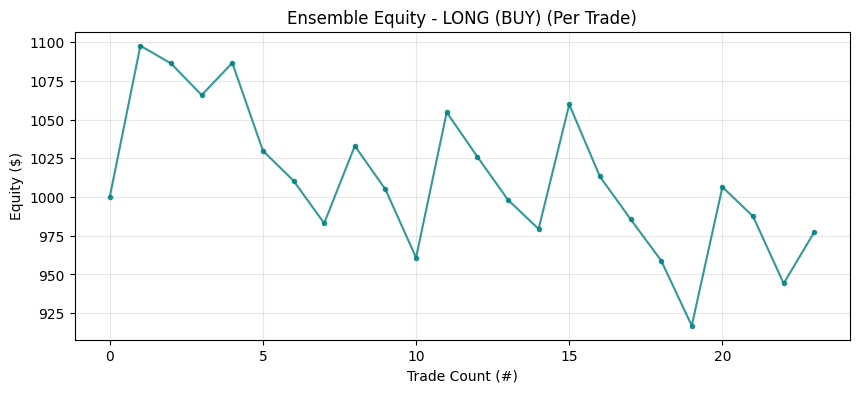


████████████████████████████████████████████████████████████
   STARTING ANALYSIS FOR: SHORT (SELL)
████████████████████████████████████████████████████████████

🛡️ Starting CPCV Analysis for SHORT
   >> Total Combinations (Paths): 15

🔄 Combination 1/15: Train_Size=33632, Test_Size=17072
   🧪 Combination 1 OOS Profit: $-13.81 | Trades: 4

🔄 Combination 2/15: Train_Size=33071, Test_Size=17072
   🧪 Combination 2 OOS Profit: $-64.47 | Trades: 12

🔄 Combination 3/15: Train_Size=33071, Test_Size=17072
   🧪 Combination 3 OOS Profit: $0.00 | Trades: 0

🔄 Combination 4/15: Train_Size=33071, Test_Size=17072
   🧪 Combination 4 OOS Profit: $0.00 | Trades: 0

🔄 Combination 5/15: Train_Size=33583, Test_Size=17072
   🧪 Combination 5 OOS Profit: $-24.43 | Trades: 5

🔄 Combination 6/15: Train_Size=33583, Test_Size=17072
   🧪 Combination 6 OOS Profit: $-39.20 | Trades: 15

🔄 Combination 7/15: Train_Size=33022, Test_Size=17072
   🧪 Combination 7 OOS Profit: $5.47 | Trades: 8

🔄 Combination 8/15: Train

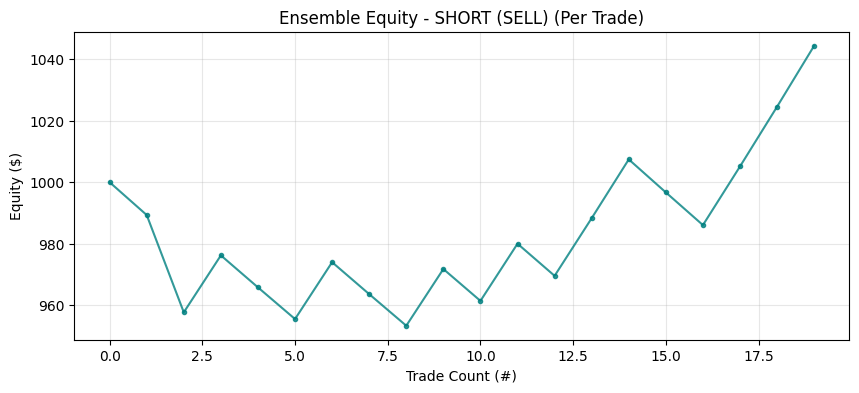

In [ ]:
# ==========================================
# 7. UPDATED MAIN EXECUTION BLOCK
# ==========================================

if __name__ == "__main__":
    try:
        drive.mount('/content/drive/')
    except: pass

    # Paths
    TRAIN_PATH = "/content/drive/MyDrive/Heuristics_Project/Phase 2/eth_5m_with_features.csv"
    TEST_PATH  = "/content/drive/MyDrive/Heuristics_Project/Phase 2/eth_5m_with_features_test.csv"

    try:
        # 1. Initialize Configuration first (Crucial for FracDiff settings)
        cfg = Config()

        # 2. Load data passing the 'cfg' object as the second argument
        df_train_full = load_data(TRAIN_PATH, cfg)
        df_test_heldout = load_data(TEST_PATH, cfg)

        # 3. Align datasets to ensure feature consistency
        df_test_heldout = align_datasets(df_train_full, df_test_heldout)

        # 4. Run Long Analysis
        profit_long = run_full_analysis("LONG (BUY)", 1, df_train_full, df_test_heldout, cfg)

        # 5. Run Short Analysis
        profit_short = run_full_analysis("SHORT (SELL)", -1, df_train_full, df_test_heldout, cfg)

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()